In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap


def run_mlr_with_different_snr_values(start_snr_value, end_snr_value, step, plot_results = False, train_on_no_noice = True):
    """
    Runs multivariate linear regression with different SNR values.
    Arguments:
    - start_snr_value: starting SNR value
    - end_snr_value: ending SNR value
    - step: step size for SNR values
    """
    results = pd.DataFrame(columns=['snr', 'rmse', 'r2', 'r2_npv'])
  
    snr_values = np.arange(start_snr_value, end_snr_value + step, step)



    if train_on_no_noice == True:
        
    
        for snr in snr_values:
            noiced_df_with_labels = pd.read_csv(
                f'/Users/zoe/Downloads/simpler_data_SNR_{snr}.csv')
        
            """
            Use this code if noiced data doesn't have the labels in the same pdf:
            noiced_df = pd.read_csv(
                f'/Users/zoe/Downloads/Simple_Data_SNR_{snr}.csv')
            training_df_no_noice = pd.read_csv('/Users/zoe/Downloads/simpler_data.csv')

            labels_df = pd.read_csv('/Users/zoe/Downloads/labels_simpler_data.csv')
        
            noiced_df_with_labels = pd.concat([labels_df, noiced_df], axis = 1)
            """
        
            testing_with_noice = noiced_df_with_labels.sample(frac=0.2, random_state=42)

            training_df_no_noice = pd.read_csv('/Users/zoe/Downloads/simpler_data.csv')

            testing_ids = testing_with_noice['Spectra'] 
        
            training_df_no_noice = training_df_no_noice[~training_df_no_noice['Spectra'].isin(testing_ids)]

     
            x_train, x_test, y_train, y_test, target_cols = training_testing_split_with_different_datasets(training_dataset = training_df_no_noice, testing_dataset = testing_with_noice)

    
            y_pred_test, model = multivariate_linear_regression(
                x_train, x_test, y_train, y_test)
        
            r2, rmse, r2_npv = evaluate_model(
                x_train, x_test, y_train, y_test, y_pred_test, model)
        
            result = pd.DataFrame([{
                'snr': snr,
                'rmse': rmse,
                'r2': r2,
                'r2_npv': r2_npv
                }])
            results = pd.concat([results, result], ignore_index=True)

            if plot_results is True:
                graph_model(y_test, y_pred_test)
                x_train_collumns_int = x_train.columns.astype(int)
                plot_npv_weights(model, x_train_collumns_int)
                plot_shap_beeswarm(model, x_train, x_test, target_index=1)

        
    else:
          for snr in snr_values:
            noiced_df_with_labels = pd.read_csv(
                f'/Users/zoe/Downloads/simpler_data_SNR_{snr}.csv')
        
            """
            Use this code if noiced data doesn't have the labels in the same pdf:
            noiced_df = pd.read_csv(
                f'/Users/zoe/Downloads/Simple_Data_SNR_{snr}.csv')
            training_df_no_noice = pd.read_csv('/Users/zoe/Downloads/simpler_data.csv')

            labels_df = pd.read_csv('/Users/zoe/Downloads/labels_simpler_data.csv')
        
            noiced_df_with_labels = pd.concat([labels_df, noiced_df], axis = 1)
            """
            x_train, x_test, y_train, y_test, target_cols = ds_preparation(ds = noiced_df_with_labels, wavelength_lim=[900, 1700], test_size=0.2)
    
            y_pred_test, model = multivariate_linear_regression(
                x_train, x_test, y_train, y_test)
            r2, rmse, r2_npv = evaluate_model(
                x_train, x_test, y_train, y_test, y_pred_test, model)
        
            result = pd.DataFrame([{
                'snr': snr,
                'rmse': rmse,
                'r2': r2,
                'r2_npv': r2_npv
                }])
            results = pd.concat([results, result], ignore_index=True)

            if plot_results is True:
                graph_model(y_test, y_pred_test)
                x_train_collumns_int = x_train.columns.astype(int)
                plot_npv_weights(model, x_train_collumns_int)
                plot_shap_beeswarm(model, x_train, x_test, target_index=1)

    print (results)
    
    results.to_excel('/Users/zoe/Downloads/mlr_trained_on_no_noice_2.xlsx')





def training_testing_split_with_different_datasets(training_dataset, testing_dataset):
    
    target_cols = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    
    x_train = training_dataset[[col for col in training_dataset.columns if col.isdigit() and 900 <= int(col) <= 1700]]
    y_train = training_dataset[target_cols]

    x_test = testing_dataset[[col for col in testing_dataset.columns if col.isdigit() and 900 <= int(col) <= 1700]]
    y_test = testing_dataset[target_cols]

   
    return x_train, x_test, y_train, y_test, target_cols
    
        


def run_standard_mlr(file="/Users/zoe/Downloads/simpler_data.csv", wavelength_lim=[900, 1700], test_size=0.2, plot_results=True):
    """
    Runs a standard multivariate linear regression model on the dataset.
    Arguments:
    - file: path to the dataset file
    - wavelength_lim: list of two integers defining the wavelength range to filter columns
    - test_size: proportion of the dataset to include in the test split
    """
    ds = open_file(file)
    x_train, x_test, y_train, y_test, target_cols = ds_preparation(ds, wavelength_lim, test_size)

    y_pred_test, model = multivariate_linear_regression(
        x_train, x_test, y_train, y_test)
    r2, rmse, r2_npv = evaluate_model(
        x_train, x_test, y_train, y_test, y_pred_test, model)

    if plot_results is True:
        graph_model(y_test, y_pred_test)
        x_train_collumns_int = x_train.columns.astype(int)
        plot_npv_weights(model, x_train_collumns_int)
        plot_shap_beeswarm(model, x_train, x_test, target_index=1)

def open_file(file):
    ds = pd.read_csv(file)
    return ds 


def ds_preparation(ds, wavelength_lim, test_size):
    """
    Prepares the dataset, filters columns based on wavelength limits, and splits into training and testing sets.
    Arguments:
    - file: path to the dataset file
    - wavelength_lim: list of two integers defining the wavelength range to filter columns
    - test_size: proportion of the dataset to include in the test split
    Returns:
    - x_train, x_test: training and testing features
    - y_train, y_test: training and testing targets 
    """
    wavelength_cols = [col for col in ds.columns if col.isdigit(
    ) and wavelength_lim[0] <= int(col) <= wavelength_lim[1]]
    target_cols = ['gv_fraction', 'npv_fraction', 'soil_fraction']
    ds_filtered = ds[wavelength_cols + target_cols]
    x = ds_filtered[wavelength_cols]
    y = ds_filtered[target_cols]
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=42)

    return x_train, x_test, y_train, y_test, target_cols


def multivariate_linear_regression(x_train, x_test, y_train, y_test):
    """
    Runs multivariate linear regression on the training data and predicts on the test data.
    Arguments:
    - x_train, x_test: training and testing features
    - y_train, y_test: training and testing targets
    Returns:
    - y_pred_test: predictions on the test set
    - model: trained linear regression model        
    """
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred_test = model.predict(x_test)
    # Ensure predictions are within [0, 1]
    y_pred_test = np.clip(y_pred_test, 0, 1)

    return (y_pred_test, model)


def evaluate_model(x_train, x_test, y_train, y_test, y_pred_test, model):
    """
    Evaluates the model performance using RMSE and R² metrics, and plots the results.
    Arguments:
    - x_train, x_test: training and testing features
    - y_train, y_test: training and testing targets
    - y_pred_test: predictions on the test set
    Returns:
    - r2, rmse, r2_npv (r2 for npv only)
    """
    # Calcultae metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2 = r2_score(y_test, y_pred_test)
    # Extract NPV values from the true and predicted results

    npv_true = y_test.iloc[:, 1].to_numpy()  # Second column for NPV
    npv_pred = y_pred_test[:, 1]  # Second column of predictions for NPV
    r2_npv = r2_score(npv_true, npv_pred)

    # Print Metrics
    r2_npv = r2_score(npv_true, npv_pred)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Test R² NPV: {r2_npv:.4f}")

    return r2, rmse, r2_npv


# Plotting Function for Results
def graph_model(y_test, y_pred_test):
    """    Plots the predicted vs true abundances for the test set.
    Arguments:
    - y_test: true target values for the test set
    - y_pred_test: predicted target values for the test set
    """
    colors = ['green', 'orange', 'saddlebrown']
    labels = ['GV', 'NPV', 'Soil']

    plt.figure(figsize=(8, 6))
    for i, (label, color) in enumerate(zip(labels, colors)):
        plt.scatter(y_test.iloc[:, i], y_pred_test[:, i],
                    label=label, alpha=0.6, edgecolor='k')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("True Abundance")
    plt.ylabel("Predicted Abundance")
    plt.title("Predicted vs True Abundances")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_npv_weights(model, x_train_collumns_int):
    """    Plots the weights of the linear regression model for the NPV fraction.
    Arguments:
    - model: trained linear regression model
    - target_cols: list of target column names (wavelengths)
    """
    npv_index = 1  # Index of 'npv_fraction' in the target list
    # Get weights for npv_fraction from the trained mvl model
    npv_weights = model.coef_[npv_index]

    plt.figure(figsize=(10, 5))
    plt.scatter(x_train_collumns_int, npv_weights, marker='o',
                linestyle='-', color='orange')
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Weight (Coefficient)")
    plt.title("Linear Regression Weights for NPV Fraction")
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()


def plot_shap_beeswarm(model, x_train, x_test, target_index):
    """    Plots SHAP values for the target abundance using a beeswarm plot.
    Arguments:
    - model: trained linear regression model
    - x_train: training features DataFrame
    - x_test: testing features DataFrame
    - target_index: index of the target column for target abundance (1 for 'npv_fraction')
        """
    # Ensure x_train and x_test are DataFrames
    if not isinstance(x_train, pd.DataFrame):
        x_train = pd.DataFrame(x_train)
        x_test = pd.DataFrame(x_test, columns=x_train.columns)

    # Define prediction function for a single target (NPV)
    def predict_function(x):
        return model.predict(x)[:, target_index]  # Only use NPV output

    # Create SHAP explainer
    explainer = shap.Explainer(predict_function, x_train)

    # Compute SHAP values for x_test
    shap_values = explainer(x_test)

    # Plot SHAP beeswarm
    print("Generating SHAP beeswarm for NPV...")
    shap.plots.beeswarm(shap_values)

"""
for list_number in [testing_with_noice.shape[0]-1]:
    spectra_name = testing_with_noice.index[list_number]
    training_df_no_noice = training_df_no_noice.drop(spectra_name)
    print(len(training_df_no_noice))
"""


'\nfor list_number in [testing_with_noice.shape[0]-1]:\n    spectra_name = testing_with_noice.index[list_number]\n    training_df_no_noice = training_df_no_noice.drop(spectra_name)\n    print(len(training_df_no_noice))\n'

Test RMSE: 0.1236
Test R²: 0.8372
Test R² NPV: 0.7855


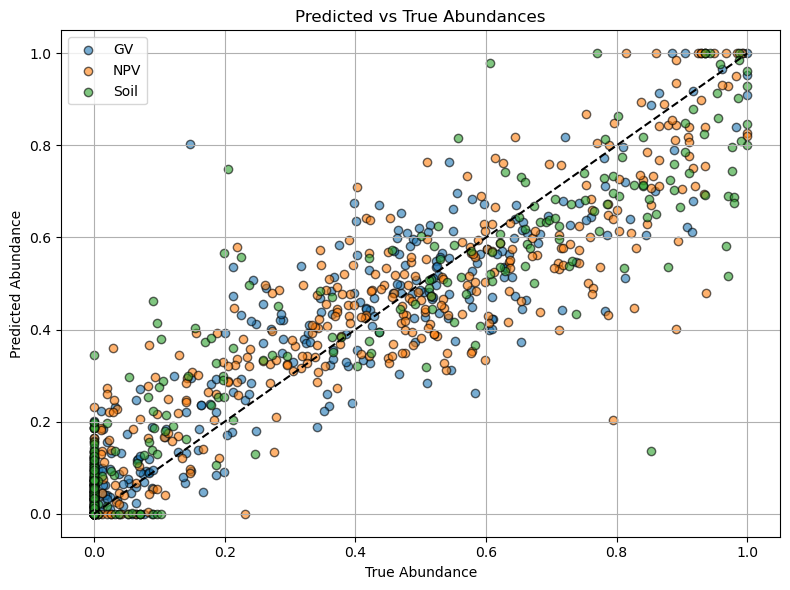

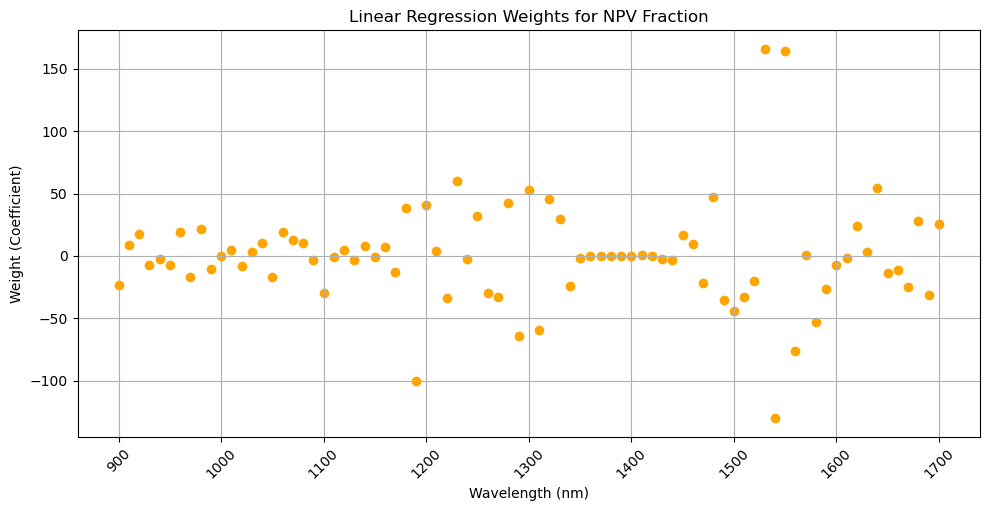

PermutationExplainer explainer: 346it [00:12,  4.49it/s]                        


Generating SHAP beeswarm for NPV...


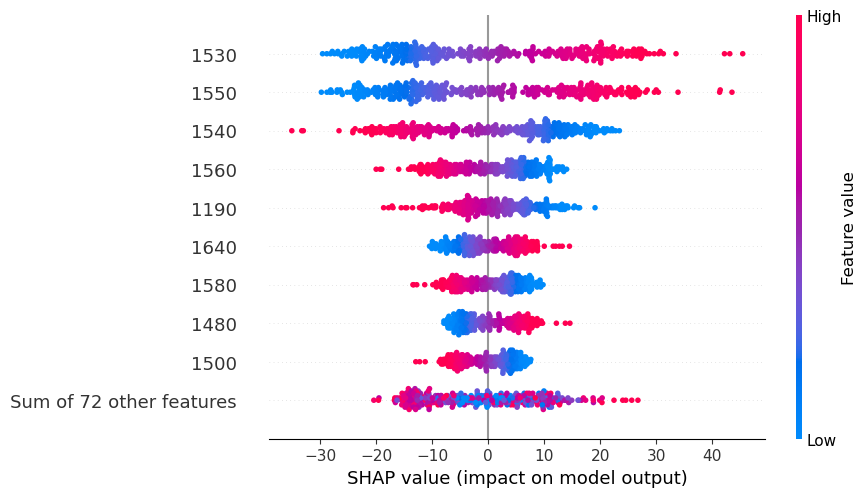

In [115]:
run_standard_mlr()